### RNA-SeQC 2: supplementary figures

This notebook contains the code for generating the supplementary figures from the manuscript. A notebook for Fig. 1 is provided [separately](Fig1.ipynb).

Metrics tables from various datasets used in the paper are provided in the [data](data) directory of this repository.

In addition to the GTEx sample annotations (see [Fig. 1 notebook](Fig1.ipynb)), files are required for reproducing fig. S6 can be downloaded by uncommenting and running the cell below (a user project needs to be provided for gsutil).

In [1]:
# !gsutil -u ${user_project} gs://gtex-resources/mappability/hg19/wgEncodeCrgMapabilityAlign36mer.patched_contigs.bigWig data/
# !wget -P data/ https://storage.googleapis.com/gtex_analysis_v7/reference/gencode.v19.transcripts.patched_contigs.gtf  
    

In [2]:
import numpy as np
import pandas as pd
import glob
import os
import copy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
matplotlib.font_manager._rebuild()
plt.rcParams.update({'font.family': 'Helvetica', 'svg.fonttype':'none', 'pdf.fonttype':42})
import seaborn as sns

import qtl.plot
import qtl.annotation
import qtl.pileup

import rnaseqc.plot

if not os.path.exists:
    os.mkdir('pdf')

#### Load inputs

In [3]:
gtex_metrics_df = pd.read_csv('data/GTEx_v8_18655_samples_RNASeQCv2.3.6.metrics.tsv.gz',
                         sep='\t', index_col=0)
ffpe_metrics_df = pd.read_csv('data/VanAllen2015_32_samples_RNASeQCv2.3.6.metrics.tsv.gz',
                              sep='\t', index_col=0)
entex_metrics_df = pd.read_csv('data/ENTEx_97_samples_RNASeQCv2.3.6.metrics.tsv.gz',
                               sep='\t', index_col=0)
cptac2_metrics_df = pd.read_csv('data/CPTAC2_CRC_105_samples_RNASeQCv2.3.6.metrics.tsv.gz',
                                sep='\t', index_col=0)
cptac3_metrics_df = pd.read_csv('data/CPTAC3_LUAD_214_samples_RNASeQCv2.3.6.metrics.tsv.gz',
                                sep='\t', index_col=0)

sample_df = pd.read_csv('data/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt',
                        sep='\t', index_col=0, low_memory=False)
sample_df = sample_df[(sample_df['SMGEBTCHT']=='TruSeq.v1') &
                      sample_df.index.str.startswith('GTEX')]
sample_df['tissue_id'] = sample_df['SMTSD'].apply(lambda x: x.replace('(','').replace(')','').replace(' - ', ' ').replace(' ', '_'))


#### Fig. S1: Quality control metrics across RNA-seq protocols

In [4]:
sample_ids = (sample_df[sample_df['tissue_id'] == 'Pancreas'].index.tolist()[:100] + 
              sample_df[sample_df['tissue_id'] == 'Cells_Cultured_fibroblasts'].index.tolist()[:100])

metrics_all_df = pd.concat([
    ffpe_metrics_df,
    cptac2_metrics_df,
    cptac3_metrics_df,
    gtex_metrics_df.loc[sample_ids],
    entex_metrics_df,
])
cohort_s = pd.Series('GTEx, polyA+', index=metrics_all_df.index)
cohort_s[entex_metrics_df.index] = 'GTEx, total RNA'
cohort_s[cptac2_metrics_df.index] = 'CPTAC, polyA+'
cohort_s[cptac3_metrics_df.index] = 'CPTAC, total RNA'
cohort_s[ffpe_metrics_df.index] = 'FFPE, capture'

cohort_colors = {
    'GTEx, polyA+':     hsv_to_rgb([0.55, 0.8, 0.6]),
    'GTEx, total RNA':  hsv_to_rgb([0.55, 0.8, 0.8]),
    'CPTAC, polyA+':    hsv_to_rgb([0.05, 0.8, 0.6]),
    'CPTAC, total RNA': hsv_to_rgb([0.05, 0.8, 0.8]),
    'FFPE, capture':    hsv_to_rgb([0.25, 0.8, 0.6]),
}

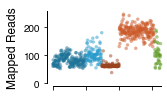

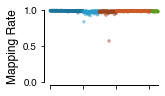

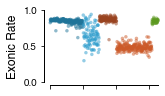

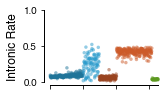

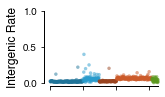

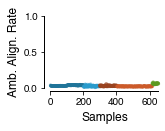

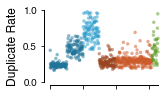

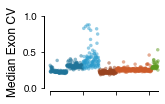

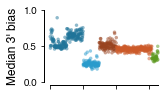

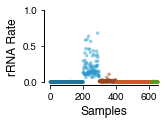

In [5]:
metrics = [
    'Mapped Reads',
    'Mapping Rate',
    'Exonic Rate',
    'Intronic Rate',
    'Intergenic Rate',
    'Ambiguous Alignment Rate',    
    'Duplicate Rate of Mapped',
    "Median Exon CV",
    "Median 3' bias",
    'rRNA Rate',
]

ylim_dict = {
    'Mapped Reads': None,
    'Mapping Rate': [0,1],
    'Duplicate Rate of Mapped': [0, 1],
    'Exonic Rate': [0, 1],
    'Intronic Rate': [0, 1],
    'Intergenic Rate': [0, 1],
    'Ambiguous Alignment Rate': [0, 1],
    'Chimeric Alignment Rate': [0, 0.1],
    'rRNA Rate': [0, 1],
    "Median 3' bias": [0, 1],
    'Median Exon CV': [0, 1],
    'Average Fragment Length': None,
}

cohorts = list(cohort_colors)
for k,metric in enumerate(metrics):
    v = metrics_all_df[metric].copy()
    v[v == 0] = np.NaN
    ax = rnaseqc.plot.metrics(v, cohort_s=cohort_s, cohort_colors=cohort_colors,
                              cohort_order=cohorts,
                                   ylim=ylim_dict[metric], ms=12, alpha=0.5, #title='',
                                   plot_density=False,
                                   ah=1, dt=0.125, db=0.5, dl=0.75, rasterized=False,
                                   aw=1.5, ds=0.25, daw=0.5, dr=0.1, #show_legend=True,
                                   )
    ax.set_xticks(np.arange(0, 800, 200))
    ax.spines['left'].set_position(('outward', 6))
    ax.spines['bottom'].set_position(('outward', 3))
    ax.set_xlabel('Samples', fontsize=12)
    ax.set_ylabel(metric.replace('Ambiguous Alignment', 'Amb. Align.').replace('Duplicate Rate of Mapped', 'Duplicate Rate'), fontsize=12)
    if metric not in ['Ambiguous Alignment Rate', 'rRNA Rate']:
        ax.set_xlabel(None)
        ax.set_xticklabels([])
    plt.savefig(f"pdf/protocols.{metric.replace(' ','_')}.pdf", dpi=300)


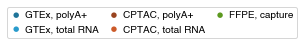

In [6]:
ax = qtl.plot.setup_figure(0, 0.5, xspace=[0.05, 4.25], yspace=[0.05, 0.05])
qtl.plot.format_plot(ax, hide=['top', 'bottom', 'left', 'right'])
ax.set_xticks([])
ax.set_yticks([])
lg = [ax.scatter([],[], s=30, c=[cohort_colors[k]], lw=0.5, edgecolor='none', label=k) for k in cohorts]
leg = ax.legend(lg, cohorts, fontsize=10, labelspacing=None, handletextpad=0.4, ncol=3, columnspacing=1,
    handlelength=1, loc='upper left', borderpad=None, borderaxespad=0, bbox_to_anchor=(1.1,1))
plt.savefig('pdf/protocols.legend2.pdf')

#### Fig. S2: Alignement rates to genomic features for 3000 GTEx samples

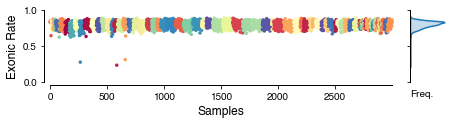

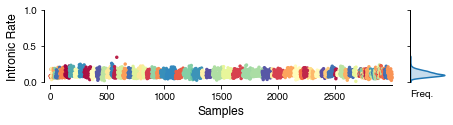

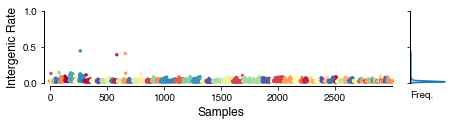

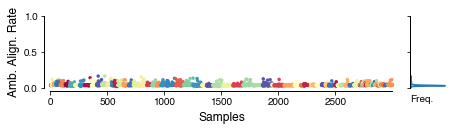

In [7]:
sample_ids = sample_df.index
cohort_s = sample_df.loc[sample_ids, 'SMGEBTCH']
date_s =   sample_df.loc[sample_ids, 'SMGEBTCHD']

num_s = cohort_s.value_counts()
sample_ids = cohort_s[cohort_s.notnull() & date_s.notnull() & cohort_s.isin(num_s[num_s>10].index)].index

cohort_s = sample_df.loc[sample_ids, 'SMGEBTCH']
date_s = sample_df.loc[sample_ids, 'SMGEBTCHD']

date_ix = pd.concat([pd.to_datetime(date_s).rename('date'), cohort_s.rename('cohort')], axis=1).sort_values(['date', 'cohort']).index
cohorts = cohort_s.loc[date_ix].unique()
nc = len(cohorts)
np.random.seed(123456)
cohort_colors = {i:j for i,j in zip(cohorts, plt.cm.get_cmap('Spectral', nc)(np.random.permutation(np.arange(nc))))}


for metric in [
    'Exonic Rate',
    'Intronic Rate',
    'Intergenic Rate',
    'Ambiguous Alignment Rate',
]:
    v = gtex_metrics_df.loc[sample_ids, metric]
    sel_ids = v.index[-5000:-2000]

    ax, dax = rnaseqc.plot.metrics(v[sel_ids], cohort_s[sel_ids], cohort_colors=cohort_colors,
                                   ylim=[0,1], ms=12, alpha=1, #title='',
                                   date_s=date_s[sel_ids],
                                   ah=1, dt=0.125, db=0.5, dl=0.75,
                                   aw=4.75, ds=0.25, daw=0.5, dr=0.25,
                                   )
    ax.set_xlim([1, 3000])
    ax.set_xticks(np.arange(0, 3000, 500))
    ax.spines['left'].set_position(('outward', 6))
    ax.spines['bottom'].set_position(('outward', 3))
    ax.set_xlabel('Samples', fontsize=12)
    ax.set_ylabel(metric.replace('Ambiguous Alignment', 'Amb. Align.'), fontsize=12)
    plt.savefig(f"pdf/{metric.replace(' ','_')}.samples.pdf", dpi=300)


#### Fig. S3: Insert size distribution

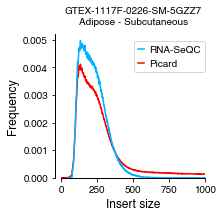

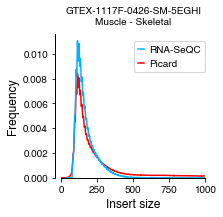

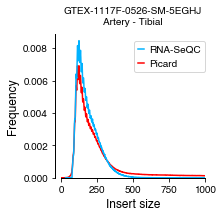

In [8]:
picard_files = {os.path.basename(i).split('.')[0]:i for i in glob.glob('/xchip/gtex/francois/github/rnaseqc2-paper/data/*.picard.output.gz')}
rnaseqc_files = {os.path.basename(i).split('.')[0]:i for i in glob.glob('/xchip/gtex/francois/github/rnaseqc2-paper/data/*.fragmentSizes.txt.gz')}

for sample_id in sorted(picard_files):
    ax = qtl.plot.setup_figure(2,2, yspace=[0.5,0.5])
    
    s = pd.read_csv(rnaseqc_files[sample_id], sep='\t', index_col=0, squeeze=True)
    s = s / s.sum()
    ax.plot(s.index, s.values, c=hsv_to_rgb([0.55,1,1]), zorder=2, label='RNA-SeQC')

    s = pd.read_csv(picard_files[sample_id], sep='\t', skiprows=10, index_col=0, squeeze=True)
    s = s / s.sum()
    ax.plot(s.index, s.values, c=hsv_to_rgb([0,1,1]), zorder=1, label='Picard')
    
    ax.legend(fontsize=10, labelspacing=None, handletextpad=0.5,
              handlelength=2/3, loc='upper right', borderpad=None, borderaxespad=0, bbox_to_anchor=(1,0.95))

    ax.set_xlim([0,1000])
    ax.set_ylim([0, ax.get_ylim()[1]])
    qtl.plot.format_plot(ax, fontsize=10)
    ax.set_xlabel('Insert size', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    tissue = sample_df.loc[sample_id, 'SMTSD']
    ax.set_title(f'{sample_id}\n{tissue}', fontsize=10, pad=10)
    ax.spines['left'].set_position(('outward', 6))
    plt.savefig(f"pdf/{sample_id}.{tissue.replace(' - ','_')}.insert_size_hist.pdf")


#### Fig. S4: Correlation between RNA-SeQC metrics

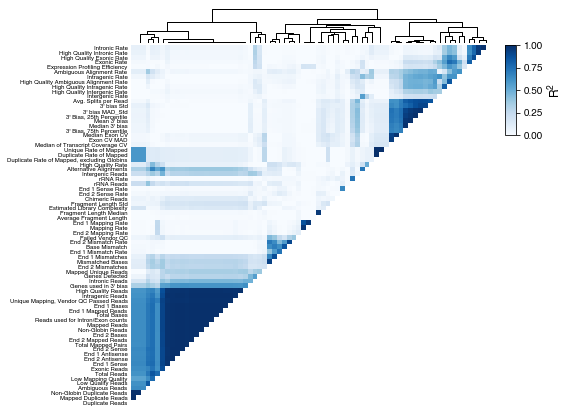

In [9]:
tissue_id = 'Liver'
sample_ids = sample_df[sample_df['tissue_id'] == tissue_id].index
df = gtex_metrics_df.loc[sample_ids].drop('Read Length', axis=1)
C = df.corr(method='pearson')

ax = qtl.plot.clustermap(C**2, aw=5, ah=5, cmap=plt.cm.Blues, vmin=0, vmax=1,
                            method='complete', metric='euclidean', optimal_ordering=True,
                            tri=True, clabel='R$^{\mathregular{2}}$',
                            dd=0.5, ch=1.25, cw=0.15, dc=0.2, fontsize=6, cfontsize=10,
                            db=0.25, dl=1.75)
ax[0].set_xticks([])
plt.savefig(f'pdf/{tissue_id}.metrics.R2_heatmap.pdf')

#### Fig. S5: Metrics capturing differences in fragment GC content distribution

In [10]:
gc_df = pd.read_csv('data/geuvadis_30_samples_RNASeQCv2.4.0.gc_content.txt.gz',
                    sep='\t', index_col=0)
norm_df = gc_df / gc_df.sum(0)
# re-bin
b = 2
norm_df = norm_df.apply(lambda s: [sum(s.values[k*b:k*b+b]) for k in range(100//b)], axis=0)

metrics_df = pd.read_csv('data/geuvadis_30_samples_RNASeQCv2.4.0.metrics.tsv.gz',
                         sep='\t', index_col=0)

metadata_df = pd.read_excel('data/Love16_Supplementary_Table_2.xlsx')

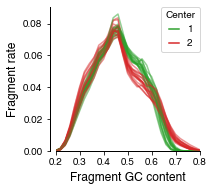

In [11]:
center_s = metadata_df.set_index('run')['center']
color_dict = {'UNIGE':'tab:red', 'CNAG_CRG':'tab:green'}

ax = qtl.plot.setup_figure(2, 2, xspace=[0.75,0.25], yspace=[0.5,0.25])
x = np.arange(0, 1, 0.01*b)
args = {'alpha':0.5}
ax.plot([], label='1', color='tab:green', alpha=1)
ax.plot([], label='2', color='tab:red',   alpha=1)
for c in gc_df.columns:
    ax.plot(x, norm_df[c].values, c=color_dict[center_s[c]], **args)    
    
ax.set_xlim([0.2, 0.8])
ax.set_ylim([0, ax.get_ylim()[1]])
qtl.plot.format_plot(ax, y_offset=6, fontsize=10)
ax.set_xticks(np.arange(0.2,0.9,0.1))
ax.set_xlabel('Fragment GC content', fontsize=12)
ax.set_ylabel('Fragment rate', fontsize=12)
ax.legend(loc='upper right', title='Center', fontsize=10, handlelength=1, borderaxespad=0)#, bbox_to_anchor=(0.5,1))
plt.savefig('pdf/sfig_gc_content.pdf')


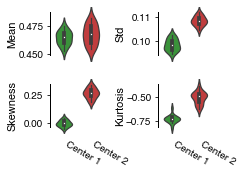

In [12]:
order = ['Center 1', 'Center 2']
color_dict = {
    'Center 1':'tab:green',
    'Center 2':'tab:red',
}

data_df2 = metrics_df.loc[metrics_df.index.str.contains('GC')].T
data_df2['center'] = metadata_df.set_index('run').loc[data_df2.index, 'center'].map(
    {'UNIGE':'Center 2', 'CNAG_CRG':'Center 1'})

ax = qtl.plot.get_axgrid(2, 2, aw=0.75, ah=0.75, dx=0.75, dy=0.25, dl=0.75, dt=0.25, dr=0.5,
                         x_offset=0, y_offset=0)
for k,c in enumerate(['GC Content Mean', 'GC Content Std', 'GC Content Skewness', 'GC Content Kurtosis']):
    ax[k].margins(0)
    sns.violinplot(x='center', y='Fragment '+c, data=data_df2, width=0.6, linewidth=1.25, scale='width',
                   order=order, palette=color_dict, ax=ax[k])
    ax[k].set_xlabel(None)
    ax[k].set_ylabel(None)
    ax[k].text(-0.8, 0.5, c.replace('GC Content ', ''), fontsize=11,
               va='center', rotation=90, transform=ax[k].transAxes)
    ax[k].spines['bottom'].set_visible(False)
    ylim = ax[k].get_ylim()
    d = ylim[1] - ylim[0]
    ax[k].spines['left'].set_bounds(ylim[0]+0.1*d, ylim[1]-0.1*d)
    ax[k].set_xticklabels(order, rotation=-30, ha='left')
    if k<2:
        ax[k].set_xticks([])
    for line in (ax[k].xaxis.get_ticklines()):
        line.set_markersize(0)
        line.set_markeredgewidth(0)
plt.savefig('pdf/sfig_gc_content_metrics.pdf')


#### Fig. S6: Exon-level variability in coverage is captured by the 'Median Exon CV' metric

In [13]:
def plot_coverage(gene, max_intron=50):
    
    pileups_df = pd.read_parquet(f'data/{gene.name}.pileups.parquet')
    pileups_df = pileups_df / pileups_df.sum() * 1e3
    
    pileups_df.columns = ffpe_metrics_df.loc[pileups_df.columns, 'Median Exon CV'].apply(
        lambda x: f'Median Exon CV = {x:.2f}')
    ax, gax,_ = qtl.pileup.plot(pileups_df, gene, mappability_bigwig=mappability_bigwig, variant_id=None,
                                order='none', max_intron=max_intron, lw=1, rasterized=True, 
                                outline=True, labels=None,
                                ah=1.25)
    leg = ax.legend(loc='upper left', labelspacing=0.15, frameon=False, fontsize=9, borderaxespad=0.5,
                     borderpad=0, handlelength=0.75, ncol=1)

    ax.spines['left'].set_position(('outward', 6))
    ax.set_ylabel('Normalized coverage', fontsize=12)
    ax.set_xlabel(f'Exon coordinates on chr{gene.chr}', fontsize=12)
    return ax, gax


annot = qtl.annotation.Annotation('data/gencode.v19.transcripts.patched_contigs.gtf', verbose=False)
mappability_bigwig = 'data/wgEncodeCrgMapabilityAlign36mer.patched_contigs.bigWig'


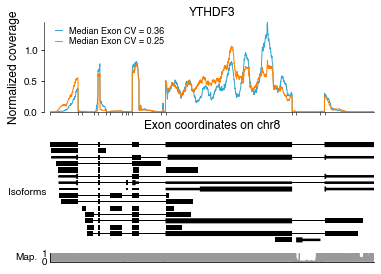

In [14]:
gene_name = 'YTHDF3'
gene = annot.get_gene(gene_name)

ax, gax = plot_coverage(gene)
xlim = list(ax.get_xlim())
xlim[0] = 0
xlim[1] -= 2475
ax.set_xlim(xlim)
ax.set_title(gene_name, fontsize=12)
plt.savefig(f'pdf/{gene_name}.exon_cv_pileups.pdf', dpi=300)


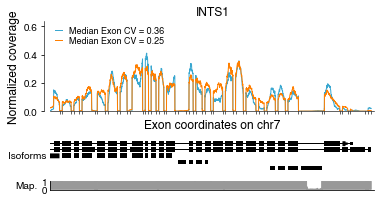

In [15]:
gene_name = 'INTS1'
gene = copy.deepcopy(annot.get_gene(gene_name))
gene.transcripts = gene.transcripts[:2] + gene.transcripts[6:]
gene.start_pos = np.min([t.start_pos for t in gene.transcripts])
gene.end_pos = np.max([t.end_pos for t in gene.transcripts])

ax, gax = plot_coverage(gene, max_intron=50)
xlim = np.array([6000, 12100])-250
ax.set_xlim(xlim)
ax.set_title(gene_name, fontsize=12)
plt.savefig(f'pdf/{gene_name}.exon_cv_pileups.pdf', dpi=300)
